# Trained or Tranformer Aproach

In [187]:
import pandas as pd
import re
import torch
from transformers import DistilBertTokenizer, DistilBertForSequenceClassification 
from torch.utils.data import DataLoader, Dataset
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler

from torch.optim import AdamW # Use the AdamW Optimizer from Pytorch and the Transformers Version

In [92]:
file_path = './dataset/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products_May19.csv'
# file_path = './dataset/Datafiniti_Amazon_Consumer_Reviews_of_Amazon_Products.csv'

In [104]:
# Step 1: Load dataset and clean text
df = pd.read_csv(file_path)

import os
os.environ["TOKENIZERS_PARALLELISM"] = "false"

In [96]:
df.head(3)

,id,dateAdded,dateUpdated,name,asins,brand,categories,primaryCategories,imageURLs,keys,...,reviews.didPurchase,reviews.doRecommend,reviews.id,reviews.numHelpful,reviews.rating,reviews.sourceURLs,reviews.text,reviews.title,reviews.username,sourceURLs
0,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,3,https://www.amazon.com/product-reviews/B00QWO9...,I order 3 of them and one of the item is bad q...,... 3 of them and one of the item is bad quali...,Byger yang,"https://www.barcodable.com/upc/841710106442,ht..."
1,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,4,https://www.amazon.com/product-reviews/B00QWO9...,Bulk is always the less expensive way to go fo...,... always the less expensive way to go for pr...,ByMG,"https://www.barcodable.com/upc/841710106442,ht..."
2,AVpgNzjwLJeJML43Kpxn,2015-10-30T08:59:32Z,2019-04-25T09:08:16Z,AmazonBasics AAA Performance Alkaline Batterie...,"B00QWO9P0O,B00LH3DMUO",Amazonbasics,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,https://images-na.ssl-images-amazon.com/images...,"amazonbasics/hl002619,amazonbasicsaaaperforman...",...,NaN,NaN,NaN,NaN,5,https://www.amazon.com/product-reviews/B00QWO9...,Well they are not Duracell but for the price i...,... are not Duracell but for the price i am ha...,BySharon Lambert,"https://www.barcodable.com/upc/841710106442,ht..."


# Exploratory Data Analysis (EDA)

In [106]:
# Verify size of the dataset
print(f"Number of rows in the dataset: {df.shape[0]}")
print(f"Number of columns in the dataset: {df.shape[1]}")

# DataSet Types
print("\nData Types: ")
print(df.info())

Number of rows in the dataset: 28332
Number of columns in the dataset: 24

Data Types: 
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 28332 entries, 0 to 28331
Data columns (total 24 columns):
 #   Column               Non-Null Count  Dtype  
---  ------               --------------  -----  
 0   id                   28332 non-null  object 
 1   dateAdded            28332 non-null  object 
 2   dateUpdated          28332 non-null  object 
 3   name                 28332 non-null  object 
 4   asins                28332 non-null  object 
 5   brand                28332 non-null  object 
 6   categories           28332 non-null  object 
 7   primaryCategories    28332 non-null  object 
 8   imageURLs            28332 non-null  object 
 9   keys                 28332 non-null  object 
 10  manufacturer         28332 non-null  object 
 11  manufacturerNumber   28332 non-null  object 
 12  reviews.date         28332 non-null  object 
 13  reviews.dateSeen     28332 non-null  object 
 14

In [100]:
# null data
print('Null values: ')
print(df.isnull().sum())

Null values: 
id                         0
dateAdded                  0
dateUpdated                0
name                       0
asins                      0
brand                      0
categories                 0
primaryCategories          0
imageURLs                  0
keys                       0
manufacturer               0
manufacturerNumber         0
reviews.date               0
reviews.dateSeen           0
reviews.didPurchase    28323
reviews.doRecommend    12246
reviews.id             28291
reviews.numHelpful     12217
reviews.rating             0
reviews.sourceURLs         0
reviews.text               0
reviews.title              0
reviews.username           5
sourceURLs                 0
dtype: int64


### Columns to Keep
- categories: Needed for the bonus summarization task by category.
- primaryCategories: Alternative or supplementary to categories.
- reviews.text: Core input for sentiment classification and summarization.
- reviews.rating: Used to label reviews as positive, neutral, or negative.
- reviews.title: Additional context; can be concatenated with review text.

In [148]:
# Load the dataset and drop irrelevant columns
columns_to_drop = [
    'id',  'name', 'dateAdded', 'dateUpdated', 'asins', 'brand', 'imageURLs', 'keys',
    'manufacturer', 'manufacturerNumber', 'reviews.id', 'reviews.date',
    'reviews.dateSeen', 'sourceURLs', 'reviews.didPurchase',
    'reviews.doRecommend',  'reviews.numHelpful', 'reviews.title',
    'reviews.sourceURLs', 'reviews.username'
]

# Drop irrelevant columns
processed_df = df.drop(columns=columns_to_drop)

# Display the remaining columns
print("Remaining columns in the dataset:", processed_df.columns)

display(processed_df.head(3))

Remaining columns in the dataset: Index(['categories', 'primaryCategories', 'reviews.rating', 'reviews.text'], dtype='object')


,categories,primaryCategories,reviews.rating,reviews.text
0,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,3,I order 3 of them and one of the item is bad q...
1,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,4,Bulk is always the less expensive way to go fo...
2,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,5,Well they are not Duracell but for the price i...


In [152]:
# Create sentiment columns and review.length for Analytics
# Map ratings to sentiment (negative, neutral, positive)
def map_rating_to_sentiment(rating):
    if rating <= 2:
        return 'negative'
    elif rating == 3:
        return 'neutral'
    else:
        return 'positive'

processed_df['sentiment'] = processed_df['reviews.rating'].apply(map_rating_to_sentiment)

# Encode sentiment labels
label_encoder = LabelEncoder()
processed_df['sentiment_label'] = label_encoder.fit_transform(processed_df['sentiment'])

# Calculate review lengths
processed_df['review_length'] = processed_df['reviews.text'].str.len()

# Print the shape of the new dataset
print("New dataset shape:", processed_df.shape)
print("Remaining columns:", processed_df.columns.tolist())

print()

processed_df.head(3)

New dataset shape: (28332, 7)
Remaining columns: ['categories', 'primaryCategories', 'reviews.rating', 'reviews.text', 'sentiment', 'sentiment_label', 'review_length']



,categories,primaryCategories,reviews.rating,reviews.text,sentiment,sentiment_label,review_length
0,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,3,I order 3 of them and one of the item is bad q...,neutral,1,139
1,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,4,Bulk is always the less expensive way to go fo...,positive,2,67
2,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,5,Well they are not Duracell but for the price i...,positive,2,56


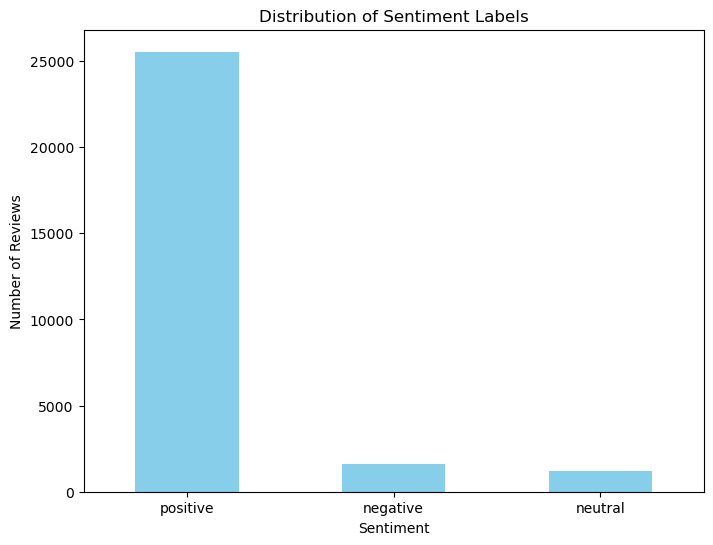

In [154]:
import matplotlib.pyplot as plt

# Distribution of sentiment labels
sentiment_counts = processed_df['sentiment'].value_counts()

# Bar plot for sentiment distribution
plt.figure(figsize=(8, 6))

sentiment_counts.plot(kind='bar', color='skyblue')
plt.title('Distribution of Sentiment Labels')
plt.xlabel('Sentiment')
plt.ylabel('Number of Reviews')
plt.xticks(rotation=0)
plt.show()

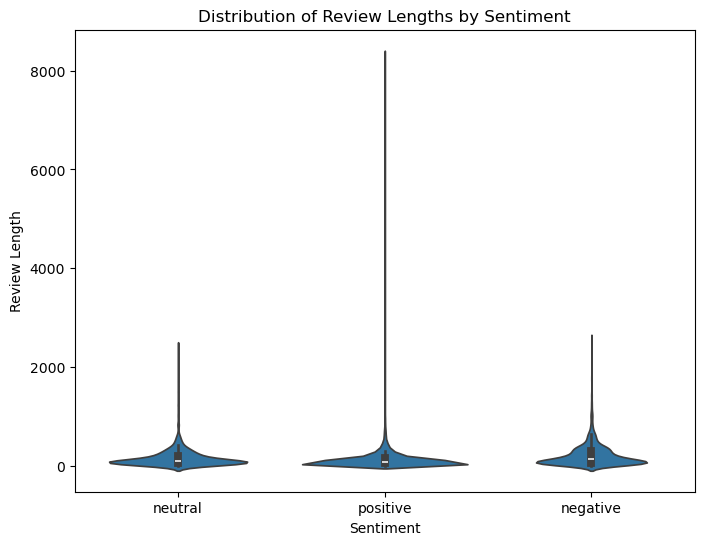

In [156]:
# Boxplot/Violinplot for review lengths by sentiment
plt.figure(figsize=(8, 6))

# sns.boxplot(data=processed_dataset, x='sentiment', y='review_length')
sns.violinplot(data=processed_df, x='sentiment', y='review_length')
plt.title('Distribution of Review Lengths by Sentiment')
plt.xlabel('Sentiment')
plt.ylabel('Review Length')
plt.show()

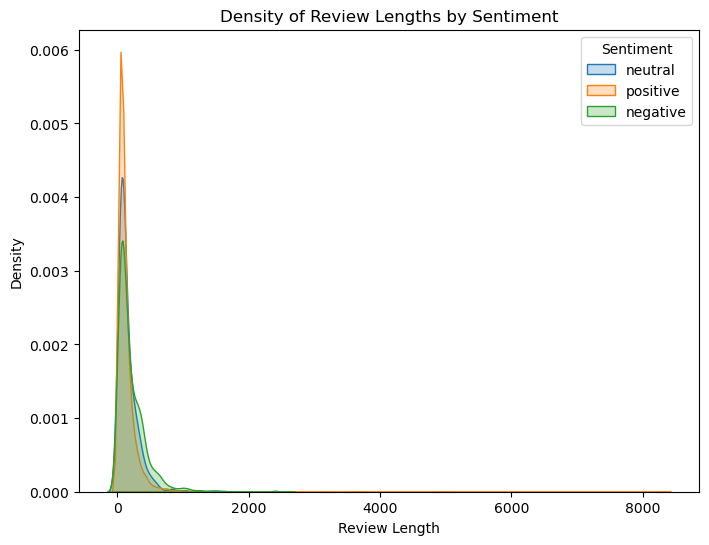

In [158]:
plt.figure(figsize=(8, 6))

# Plot density for each sentiment
for sentiment in processed_df['sentiment'].unique():
    subset = processed_df[processed_df['sentiment'] == sentiment]['review_length']
    sns.kdeplot(subset, label=sentiment, fill=True)

plt.title('Density of Review Lengths by Sentiment')
plt.xlabel('Review Length')
plt.ylabel('Density')
plt.legend(title='Sentiment')
plt.show()

### EDA Insights

#### - Possible training weights for the Neutral and Negative classifications are low. It is important to use the largest possible dataset.

#### - The text length for the "reviews" in some cases exceeds 500 words, which affects the selection of a pre-trained model due to token size limitations. Additionally, it is worth considering the removal of "reviews" with fewer than 51 words, as they may be expensive or unnecessary for identifying meaningful correlations.

# Data Transformation

### Clean and Transform the Reviews

In [160]:
def clean_text(text):
    # Convert to lowercase
    text = text.lower().strip()
    # Remove special characters (non-alphanumeric)
    text = re.sub(r'[^a-z0-9\s]', ' ', text)
    # Replace multiple spaces with a single space
    text = re.sub(r'\s+', ' ', text)
    return text

processed_df['cleaned_text'] = processed_df['reviews.text'].astype(str).apply(clean_text)

processed_df.head(3)

,categories,primaryCategories,reviews.rating,reviews.text,sentiment,sentiment_label,review_length,cleaned_text
0,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,3,I order 3 of them and one of the item is bad q...,neutral,1,139,i order 3 of them and one of the item is bad q...
1,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,4,Bulk is always the less expensive way to go fo...,positive,2,67,bulk is always the less expensive way to go fo...
2,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,5,Well they are not Duracell but for the price i...,positive,2,56,well they are not duracell but for the price i...


### Filter texts between 51 and 500 characters

In [165]:
# Filter texts between 51 and 500 characters
filtered_df = processed_df[(processed_df['cleaned_text'].apply(len) >= 51) & (processed_df['cleaned_text'].apply(len) <= 500)].copy()

print(f"Original dataset size: {len(processed_df)}")
print(f"Filtered dataset size: {len(filtered_df)}")
print()

filtered_df.head(3)

Original dataset size: 28332
Filtered dataset size: 21065



,categories,primaryCategories,reviews.rating,reviews.text,sentiment,sentiment_label,review_length,cleaned_text
0,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,3,I order 3 of them and one of the item is bad q...,neutral,1,139,i order 3 of them and one of the item is bad q...
1,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,4,Bulk is always the less expensive way to go fo...,positive,2,67,bulk is always the less expensive way to go fo...
2,"AA,AAA,Health,Electronics,Health & Household,C...",Health & Beauty,5,Well they are not Duracell but for the price i...,positive,2,56,well they are not duracell but for the price i...


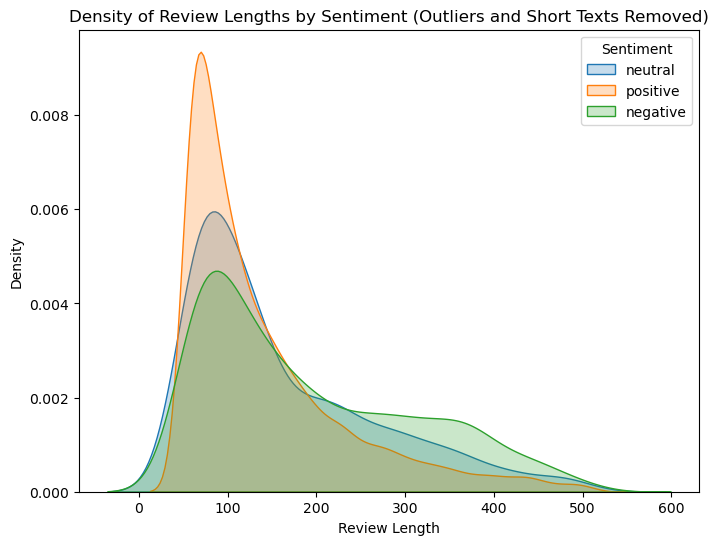

In [195]:
plt.figure(figsize=(8, 6))

# Plot density for each sentiment
for sentiment in filtered_df['sentiment'].unique():
    subset = filtered_df[filtered_df['sentiment'] == sentiment]['review_length']
    sns.kdeplot(subset, label=sentiment, fill=True)

plt.title('Density of Review Lengths by Sentiment (Outliers and Short Texts Removed)')
plt.xlabel('Review Length')
plt.ylabel('Density')
plt.legend(title='Sentiment')
plt.show()

In [167]:
# Train-test split
train_texts, val_texts, train_labels, val_labels = train_test_split(
    filtered_df['cleaned_text'].tolist(), 
    filtered_df['sentiment_label'].tolist(), 
    test_size=0.2, 
    random_state=42
)

In [169]:
# Tokenization using DistilBERT
# To CAPTURE CONTEXT RELATIONS BETWEEN WORDS
tokenizer = DistilBertTokenizer.from_pretrained('distilbert-base-uncased') # Use the DistilBert specific Tokenizer

train_encodings = tokenizer(
    train_texts, 
    padding=True, 
    truncation=True, 
    max_length=512, 
    return_tensors='pt'
)

val_encodings = tokenizer(
    val_texts, 
    padding=True, 
    truncation=True, 
    max_length=512, 
    return_tensors='pt'
)

In [11]:
# Print the first tokenized vector (input_ids) from the training dataset
print("Tokenized vector (input_ids) for the first text in the training dataset:")
print(train_encodings['input_ids'][0])

Tokenized vector (input_ids) for the first text in the training dataset:
tensor([ 101, 3835, 2946, 3898, 2200, 3435, 3733, 2000, 2224, 3835, 2946, 3835,
        3898,  102,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0])


In [12]:
# Convert token IDs back to original tokens (words/subwords)
tokens = tokenizer.convert_ids_to_tokens(train_encodings['input_ids'][0])
print("\nOriginal tokens for the first text:")
print(tokens)


Original tokens for the first text:
['[CLS]', 'nice', 'size', 'screen', 'very', 'fast', 'easy', 'to', 'use', 'nice', 'size', 'nice', 'screen', '[SEP]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '[PAD]', '

In [170]:
# Dataset class for PyTorch (torch.utils.data.Dataset)
class ReviewsDataset(Dataset): 
    def __init__(self, encodings, labels):
        self.encodings = encodings # tokenized texts (input_ids - ids for each word, attention_mask - positions ignores)
        self.labels = torch.tensor(labels) # samples from the dataset

    def __len__(self):
        return len(self.labels) # dataset tags used to classify (prositive, neutral, negative)

    def __getitem__(self, idx): # tags to tensors - get a sample from the dataset
        return {
            'input_ids': self.encodings['input_ids'][idx],
            'attention_mask': self.encodings['attention_mask'][idx],
            'labels': self.labels[idx]
        }

# Create dataset objects
train_dataset = ReviewsDataset(train_encodings, train_labels)
val_dataset = ReviewsDataset(val_encodings, val_labels)

In [173]:
# DataLoader for batching / Set the train and validation data number of batchs for each epoch train
train_loader = DataLoader(train_dataset, batch_size=8, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=8)

In [175]:
# Initialize DistilBERT model
device = torch.device('cuda') if torch.cuda.is_available() else torch.device('cpu')

model = DistilBertForSequenceClassification.from_pretrained('distilbert-base-uncased', num_labels=len(label_encoder.classes_)).to(device)

Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.bias', 'classifier.weight', 'pre_classifier.bias', 'pre_classifier.weight']
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [ ]:
#### Optimizer and training loop

In [177]:
# Optimizer and training loop
from torch.optim import AdamW

optimizer = AdamW(model.parameters(), lr=5e-5) # Pytorch Optimizer Version

epochs = 7
for epoch in range(epochs): # Trainning Loop
    print(f'Epoch {epoch + 1} ....')
    model.train()
    total_loss = 0

    for batch in train_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        # Forward pass
        outputs = model(input_ids, attention_mask=attention_mask, labels=labels)
        loss = outputs.loss
        total_loss += loss.item()

        # Backward pass
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

    avg_train_loss = total_loss / len(train_loader)
    print(f'Epoch {epoch + 1}, Training Loss: {avg_train_loss:.4f}')


Epoch 1 ....
Epoch 1, Training Loss: 0.2389
Epoch 2 ....
Epoch 2, Training Loss: 0.1460
Epoch 3 ....
Epoch 3, Training Loss: 0.1001
Epoch 4 ....
Epoch 4, Training Loss: 0.0679
Epoch 5 ....
Epoch 5, Training Loss: 0.0502
Epoch 6 ....
Epoch 6, Training Loss: 0.0385
Epoch 7 ....
Epoch 7, Training Loss: 0.0312


In [17]:
# Validation and predictions
model.eval()
all_predictions = []
all_true_labels = []

with torch.no_grad():
    for batch in val_loader:
        input_ids = batch['input_ids'].to(device)
        attention_mask = batch['attention_mask'].to(device)
        labels = batch['labels'].to(device)

        outputs = model(input_ids, attention_mask=attention_mask)
        predictions = torch.argmax(outputs.logits, dim=1)

        # Collect predictions and true labels
        all_predictions.extend(predictions.cpu().numpy())
        all_true_labels.extend(labels.cpu().numpy())


Classification Report:
              precision    recall  f1-score   support

    negative       0.86      0.78      0.82       247
     neutral       0.73      0.58      0.64       177
    positive       0.97      0.99      0.98      3789

    accuracy                           0.96      4213
   macro avg       0.86      0.78      0.81      4213
weighted avg       0.96      0.96      0.96      4213



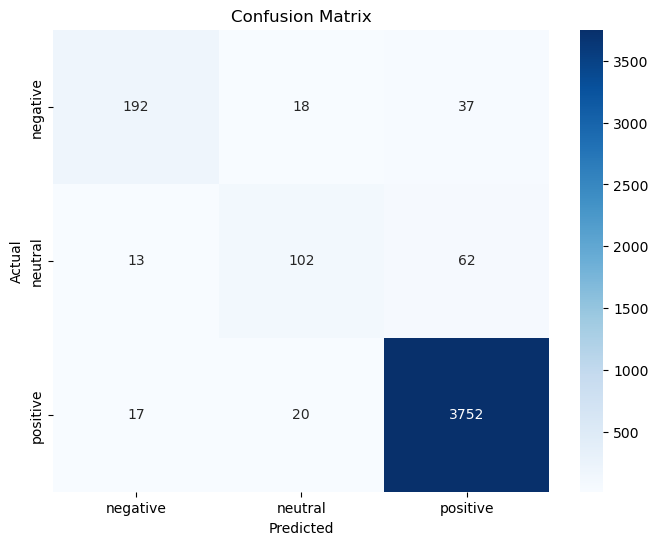

In [18]:
# Generate classification report and confusion matrix
print("\nClassification Report:")
print(classification_report(all_true_labels, all_predictions, target_names=label_encoder.classes_))

# Confusion matrix
conf_matrix = confusion_matrix(all_true_labels, all_predictions)

# Plot confusion matrix
plt.figure(figsize=(8, 6))
sns.heatmap(conf_matrix, annot=True, fmt='d', cmap='Blues', xticklabels=label_encoder.classes_, yticklabels=label_encoder.classes_)
plt.xlabel('Predicted')
plt.ylabel('Actual')
plt.title('Confusion Matrix')
plt.show()

# Save the New Trained Model

In [211]:
model.save_pretrained('./distilbert_sentiment_model')
tokenizer.save_pretrained('./distilbert_sentiment_model')

('./distilbert_sentiment_model/tokenizer_config.json',
 './distilbert_sentiment_model/special_tokens_map.json',
 './distilbert_sentiment_model/vocab.txt',
 './distilbert_sentiment_model/added_tokens.json')